In [35]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 103
hour = 0
band = 8

In [36]:
prefix = 'https://' + bucket_name + '.s3.amazonaws.com/'

In [11]:
import numpy as np
import xarray as xr
import metpy
from os import mkdir
from os import path as op
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import seaborn as sns
import dask
import string
sns.set(style="darkgrid")

DATA_PATH='../goesdata'
%matplotlib inline

In [12]:
rad_data_file = 'OR_ABI-L1b-RadF-M6C08_G16_s20191030000200_e20191030009508_c20191030009558.nc'

In [13]:
myFile= xr.open_dataset(op.join(DATA_PATH,rad_data_file))

In [14]:
# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat = myFile.metpy.parse_cf('Rad')

/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [15]:
# Geostationary projections
geos = dat.metpy.cartopy_crs

cartopy_extent_goes = geos.x_limits + geos.y_limits
pyresample_extent_goes = (cartopy_extent_goes[0],
                            cartopy_extent_goes[2],
                            cartopy_extent_goes[1],
                            cartopy_extent_goes[3])
goes_params = geos.proj4_params
rad = dat.data

In [16]:
def normIm(im,gamma=1.0,reverse=False):
    nim = ((im-np.nanmin(im))*(np.nanmax(im)-np.nanmin(im))**(-1))
    if reverse:#want clouds to be white
        nim = (1.0-nim**(gamma))
    return nim

In [17]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

roi_extent_pc_cartopy = [-109.59326, -102.40674, 
                          8.94659, -8.94656]
roi_extent_mc = mc.transform_points(pc, 
                    np.array(roi_extent_pc_cartopy[:2]),
                    np.array(roi_extent_pc_cartopy[2:])).ravel()
roi_extent_mc_cartopy = [
    roi_extent_mc[0],
    roi_extent_mc[3],
    roi_extent_mc[1],
    roi_extent_mc[4]
]
roi_extent_mc_pyresample = [
    roi_extent_mc[0],
    roi_extent_mc[1],
    roi_extent_mc[3],
    roi_extent_mc[4]
]

In [18]:
rad_image_ma = np.ma.masked_array(rad)
goes_params = geos.proj4_params
# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
goes_area = geometry.AreaDefinition('From GOES', 'Region of Interest',
                                'To Mercator', goes_params,
                               rad.shape[1], rad.shape[0],
                              pyresample_extent_goes)
area_mc_def = geometry.AreaDefinition('areaTest', 'Equator-ROW', 'areaTest',
                                  mc.proj4_params,
                                    500, 200,
                                   roi_extent_mc_pyresample)
geos_con_nn = image.ImageContainerNearest(rad_image_ma, 
                                            goes_area, 
                                            radius_of_influence=50000)

# Here we are using pyresample for the remapping
area_mc_con_nn = geos_con_nn.resample(area_mc_def)
image_mc = area_mc_con_nn.image_data



Text(0.0, 1.0, 'GOES-17')

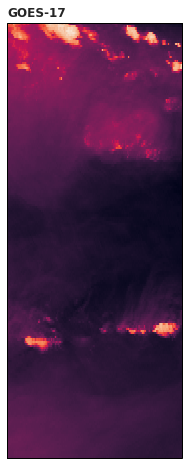

In [19]:
fig_4 = plt.figure(figsize=(15, 8))

ax_4 = fig_4.add_subplot(1, 1, 1, projection=mc)

ax_4.set_extent(roi_extent_mc_cartopy, crs=mc)


# GOES17
ax_4.imshow(normIm(image_mc,gamma=1,reverse=True), origin='upper',
           extent=roi_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_4.set_title('GOES-17', loc='left', fontweight='bold')


In [20]:
planck_fk1 = float(myFile['planck_fk1'].data)
planck_fk2 = float(myFile['planck_fk2'].data) 
planck_bc1 = float(myFile['planck_bc1'].data)                       
planck_bc2 = float(myFile['planck_bc2'].data)     


In [21]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [22]:
# Map all brightnesses to temps first
T = Rad2BT(image_mc, planck_fk1, planck_fk2, planck_bc1, planck_bc2)

In [23]:
# Then take there mean. That is different
T.mean()

243.53596

In [24]:
# Then average the radiances 
image_mc.mean()

3.6720772

In [25]:
# And then mapping this to a BT
Rad2BT(image_mc.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

243.84624228467075

## Given loaded data, and a target extent return ROI array

In [26]:
myFile.platform_ID

'G16'

In [27]:
def goes_2_roi(loaded_goes, 
               target_extent,
               target_rows,
               target_cols,
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):
    """Function that goes from loaded GOES data to data resampled in a projection for an extent"""
    dat = loaded_goes.metpy.parse_cf('Rad')
    geos_crs = dat.metpy.cartopy_crs
    cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
    pyresample_source_extent = (cartopy_source_extent[0],
                                cartopy_source_extent[2],
                                cartopy_source_extent[1],
                                cartopy_source_extent[3])
    rad = dat.data
    source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk','GOES-1X', 
                                          geos_crs.proj4_params,
                                          rad.shape[1], rad.shape[0],
                                          pyresample_source_extent)
    area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                        cartopy_target_proj.proj4_params,
                                        target_rows, target_cols,
                                        target_extent)
    geos_con_nn = image.ImageContainerNearest(rad, 
                                            source_area, 
                                            radius_of_influence=radius_of_influence)

    # Here we are using pyresample for the remapping
    area_proj_con_nn = geos_con_nn.resample(area_mc_def)
    return area_proj_con_nn.image_data
        
def cartopy_pyresample_toggle_extent(input_extent):
    return np.array(input_extent)[np.array([0,2,1,3])]

def trasform_cartopy_extent(source_extent,source_proj, target_proj):
    target_extent = target_proj.transform_points(source_proj, 
                                                 np.array(source_extent[:2]),
                                                 np.array(source_extent[2:])).ravel()
    # target_extent in 3D, must be in 2D
    return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])

In [28]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

# Convert extent from pc to mc (both cylindrical projections)
extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]


In [29]:
target_extent_mc_cartopy = trasform_cartopy_extent(extent_pc, pc, mc)
target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
print('target_extent_mc_pyresample',target_extent_mc_pyresample)
print('target_extent_mc_cartopy',target_extent_mc_cartopy)
print('roi_extent_mc_cartopy',roi_extent_mc_cartopy)

target_extent_mc_pyresample [-12199865.89757484    993361.38872422 -11399866.15059916
   -993358.03009699]
target_extent_mc_cartopy [-12199865.89757484 -11399866.15059916    993361.38872422
   -993358.03009699]
roi_extent_mc_cartopy [-12199865.897574836, -11399866.150599161, 993361.388724224, -993358.0300969948]


In [30]:
roi_rads = goes_2_roi(myFile,
               target_extent_mc_pyresample,
               500,
               200,
               mc)

/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Text(0.0, 1.0, 'GOES-17')

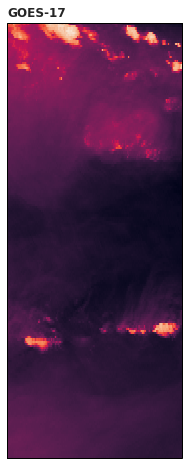

In [31]:

fig_5 = plt.figure(figsize=(15, 8))

ax_5 = fig_5.add_subplot(1, 1, 1, projection=mc)

ax_5.set_extent(target_extent_mc_cartopy, crs=mc)


# GOES17
ax_5.imshow(normIm(roi_rads,gamma=1.0,reverse=True), origin='upper',
           extent=target_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_5.set_title('GOES-17', loc='left', fontweight='bold')

In [32]:
new_DATA_PATH = '../written_rad_data'

try:
    mkdir(new_DATA_PATH)
except:
    pass

np_file = 'im_'+ str(rad_data_file)[:-3]

full_filename = op.join(new_DATA_PATH, np_file)

np.save(full_filename,roi_rads)

In [33]:
roi_rads = goes_2_roi(myFile,
               target_extent_mc_pyresample,
               500,
               200,
               mc)

/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/jalvarez/.conda/envs/jalvarez/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Text(0.0, 1.0, 'GOES-17')

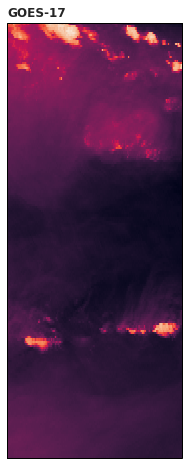

In [34]:

fig_6 = plt.figure(figsize=(15, 8))

ax_6 = fig_6.add_subplot(1, 1, 1, projection=mc)

ax_6.set_extent(target_extent_mc_cartopy, crs=mc)


# GOES17
ax_6.imshow(normIm(roi_rads,gamma=1.0,reverse=True), origin='upper',
           extent=target_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_6.set_title('GOES-17', loc='left', fontweight='bold')